# Deep drawing 3D shape prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import os
import sys
sys.path.insert(0, "../../src")
from cut_predictor import ProjectionPredictor

## Load the pretrained network

In [2]:
reg = ProjectionPredictor()
reg.load_config('../../models/springback_uvmap_xyz.pkl')
reg.load_network('../../models/best_uv_xyz_model/')

A nicer visualization method with plotly, a faster one with matplotlib

In [3]:
param = {
        'Blechdicke': 1.01, 
        'Niederhalterkraft': 110.0, 
        'Ziehspalt': 2.4, 
        'Einlegeposition': -5, 
        'Ziehtiefe': 30,
        'Stempel_ID': 3,
        'E': 191.37245,
        'Rp0': 238.22696,
        'Rp50': 449.528189,
    }

In [4]:
df = pd.DataFrame({"v": np.linspace(0.,1,100), "u": .5})
dfr = reg.predict(param, df)
dfr

1/1 [==============================] - 0s 153ms/step


,v,u,x,y,z
0,0.000000,0.5,0.014267,-94.826859,2.014291
1,0.010101,0.5,-0.012421,-90.853508,2.028922
2,0.020202,0.5,-0.249634,-86.664955,2.101868
3,0.030303,0.5,-0.327362,-82.322403,2.168966
4,0.040404,0.5,-0.547134,-78.078232,2.160779
...,...,...,...,...,...
95,0.959596,0.5,1.520844,79.650749,2.368178
96,0.969697,0.5,1.617126,83.992760,2.605947
97,0.979798,0.5,1.627792,88.214928,2.876570
98,0.989899,0.5,1.683853,92.448250,3.229417


1/1 [==============================] - 0s 13ms/step


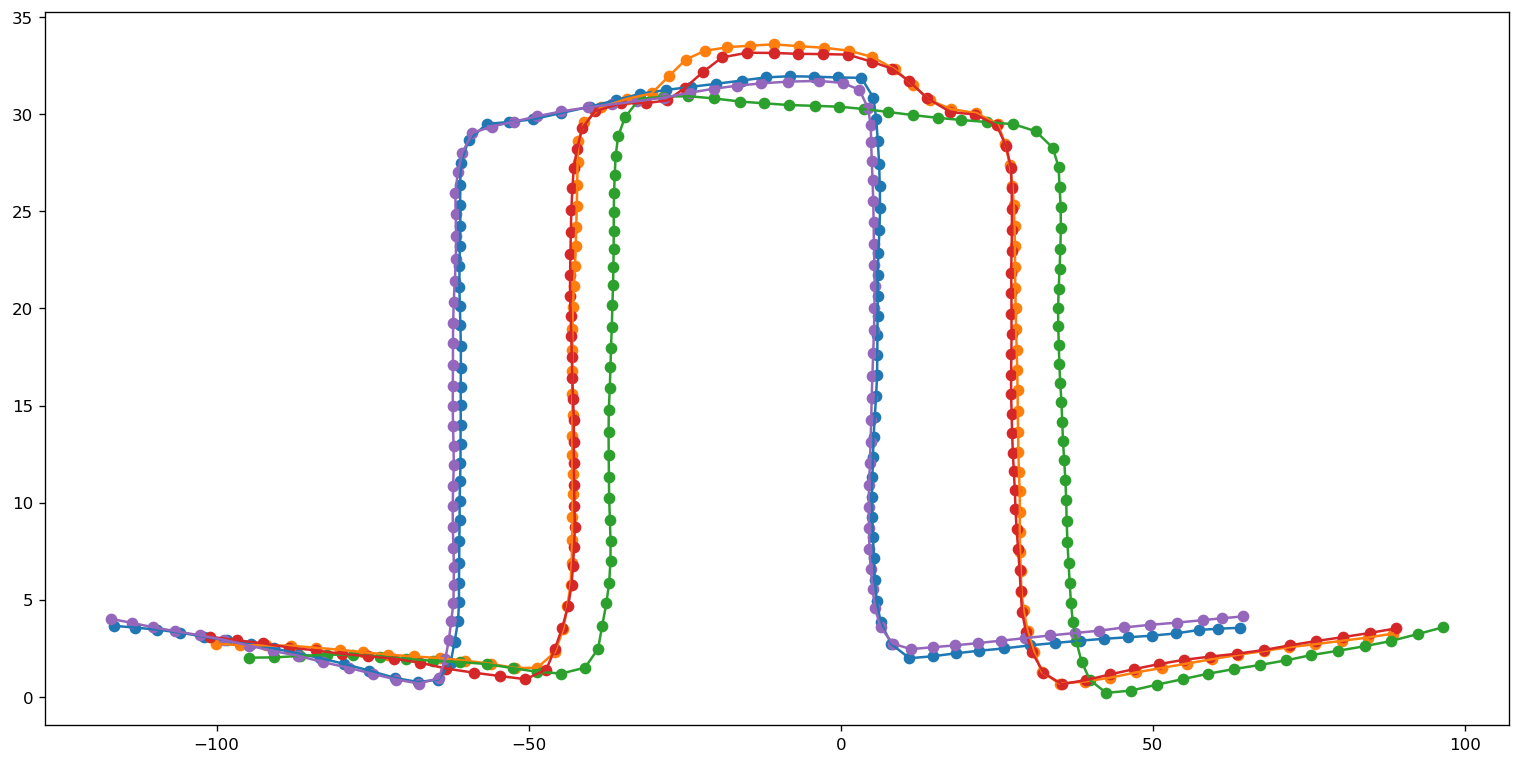

In [5]:
B = 400/25.4
H = 200/25.4
fig, ax = plt.subplots(1, figsize=(B, H))
for u in np.linspace(0.,1,5):
    df = pd.DataFrame({"v": np.linspace(0.,1,100), "u": u})
    dfr = reg.predict(param, df)
    ax.scatter(dfr.y, dfr.z)
    ax.plot(dfr.y, dfr.z)

In [6]:
import scale.fem.lsdyna.api as api
mesh2d = api.BoxMesh2d(size=[1,1,0], elsize=.01, pid=1)
mesh2d.gen_box()
mesh2d.info()
mesh2d.fix_column_types()
mesh2d.nodes.dtypes

nid      int64
x      float64
y      float64
z      float64
dtype: object

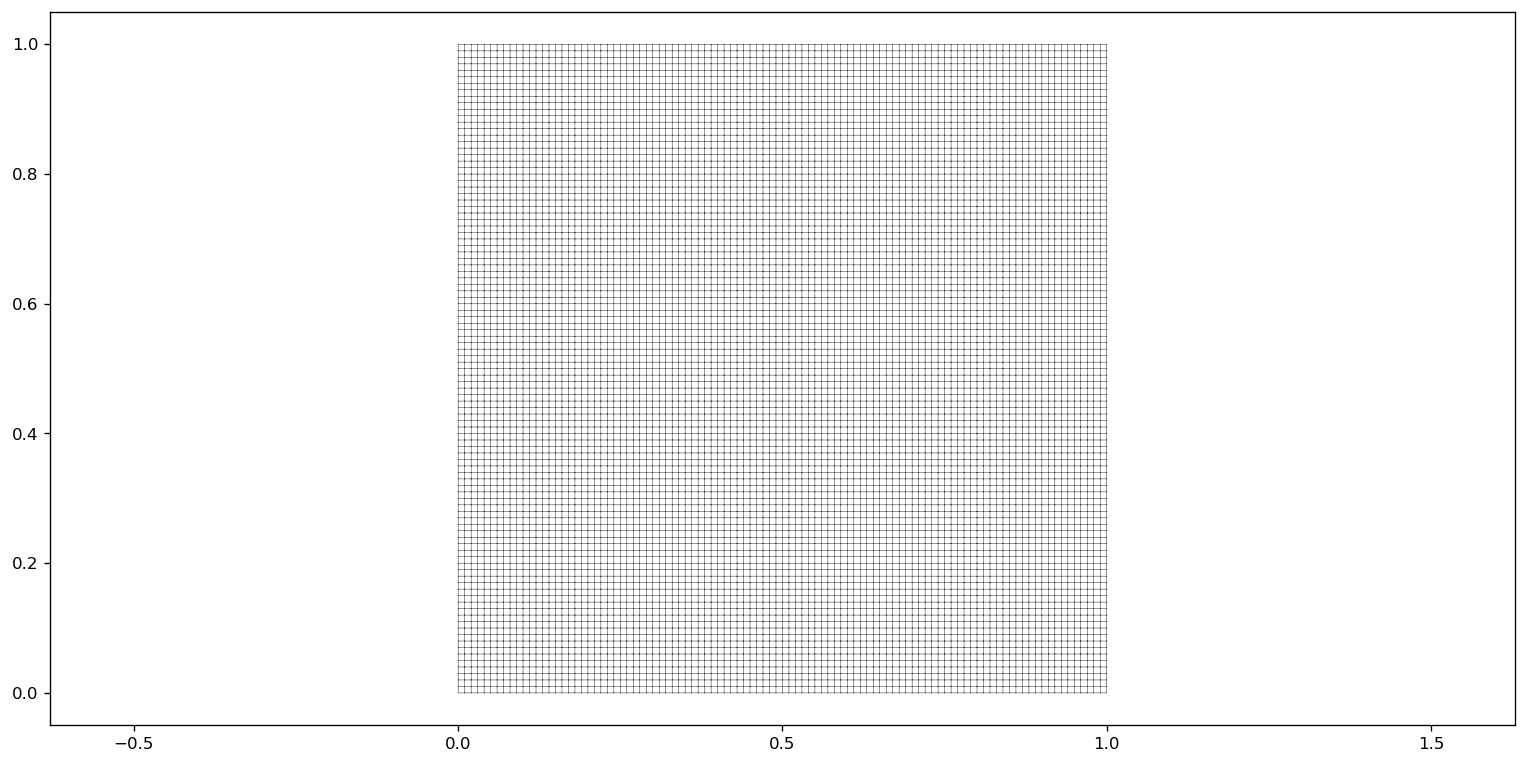

In [7]:
B = 400/25.4
H = 200/25.4
fig, ax = plt.subplots(1, figsize=(B, H))
ax.set_aspect("equal", "datalim")
mesh2d.plot_mpl(ax=ax)


In [11]:
mesh = mesh2d.copy()
mesh.nodes = mesh.nodes.rename(columns={"x":"u", "y":"v", "z":"w"})
param = {
        'Blechdicke': 1.01, 
        'Niederhalterkraft': 110.0, 
        'Ziehspalt': 2.4, 
        'Einlegeposition': -5, 
        'Ziehtiefe': 30,
        'Stempel_ID': 3,
        'E': 191.37245,
        'Rp0': 238.22696,
        'Rp50': 449.528189,
    }
mesh.nodes = reg.predict(param, mesh.nodes)
mesh.nodes

3/3 [==============================] - 0s 13ms/step


,nid,u,v,w,x,y,z
1,1,0.00,0.0,0.0,-129.793427,-116.444946,3.653793
2,2,0.01,0.0,0.0,-127.527512,-115.722969,3.645916
3,3,0.02,0.0,0.0,-125.187134,-114.989967,3.661291
4,4,0.03,0.0,0.0,-122.746513,-114.223160,3.674106
5,5,0.04,0.0,0.0,-120.247223,-113.400284,3.667163
...,...,...,...,...,...,...,...
10197,10197,0.96,1.0,0.0,179.197693,68.126442,4.070310
10198,10198,0.97,1.0,0.0,183.589386,66.998207,4.091048
10199,10199,0.98,1.0,0.0,188.194275,65.928993,4.120282
10200,10200,0.99,1.0,0.0,192.697327,65.071556,4.121259


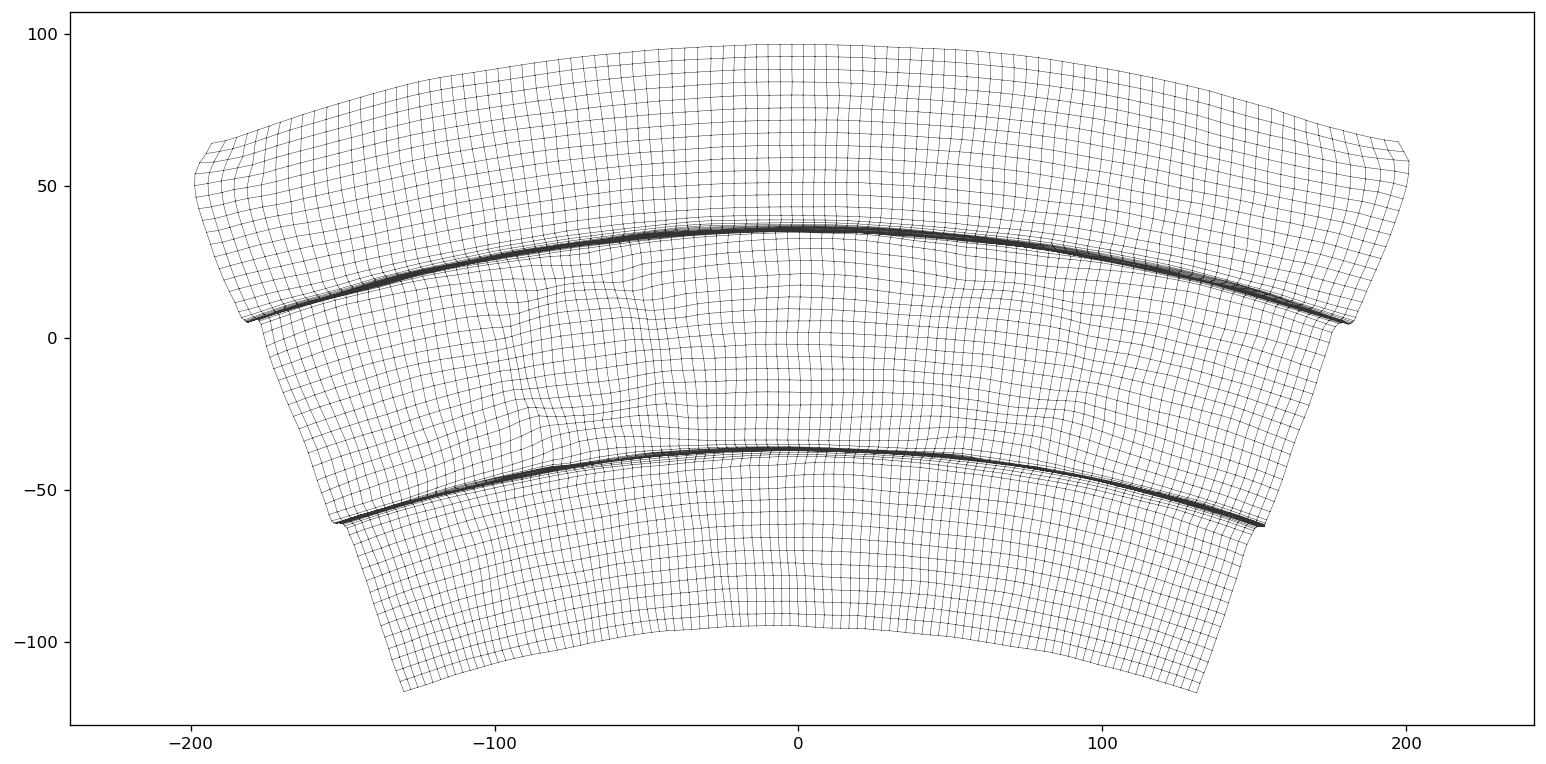

In [12]:
B = 400/25.4
H = 200/25.4
fig, ax = plt.subplots(1, figsize=(B, H))
ax.set_aspect("equal", "datalim")
mesh.plot_mpl(ax=ax)

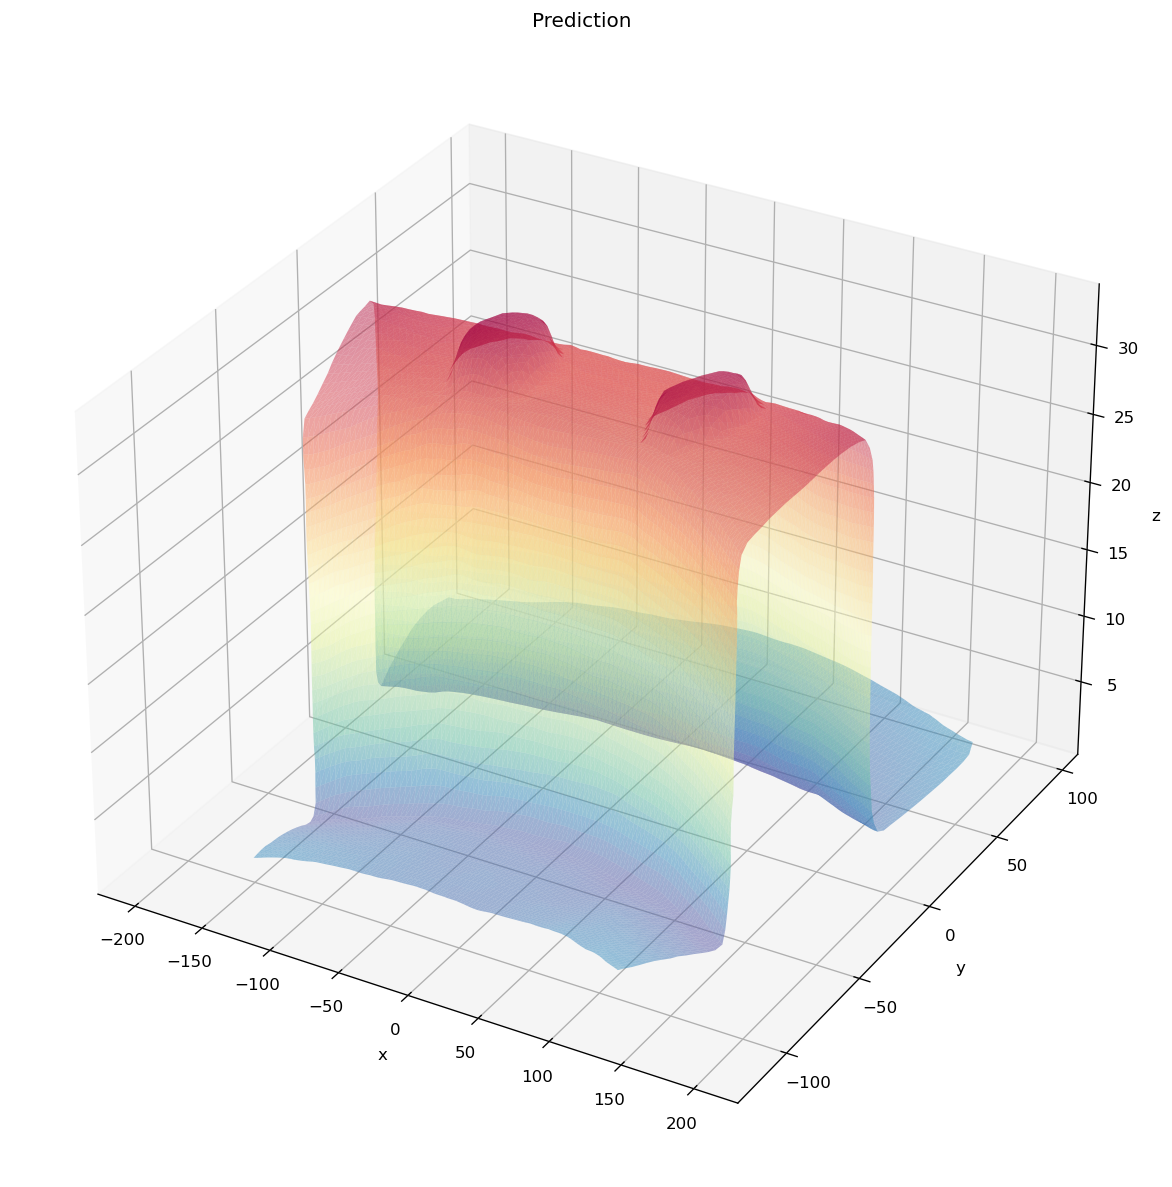

In [16]:
mesht = api.TriaMesh.from_mesh(mesh)
fig = plt.figure(1, figsize=(18,10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_trisurf(mesht.nodes.x, mesht.nodes.y, mesht.nodes.z, 
                triangles=mesht.simplices(), cmap=plt.cm.Spectral_r, 
                alpha=.5, shade=False)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title(f"Prediction")
fig.tight_layout()